In [1]:
setwd('..')

## Daily Cases by Colorado County

In [2]:
# helper functions for computing LQ and rates
source('code/support_functions.R')

County population counts are also based on ACS 5-year estimates for 2018 and were acquired from the [Social Explorer Database](https://socialexplorer.com).

In [3]:
## prep total population data
# county population (sex by age, aggregates to total county pop)
co_sxa <- read.csv('data/co_sex_by_age_by_county_acs_2018_5yr.csv',
                   stringsAsFactors = F) 

# subset the county ID and total population columns
co_pop <- co_sxa[,c('Geo_NAME', 'ACS18_5yr_B01001001')]

# rename total population column
names(co_pop)[2] <- 'pop'

In [4]:
# some of the earlier dates don't have the ` County` suffix,
# so remove this from the total population count IDs
co_pop$Geo_NAME <- gsub(' County', '', co_pop$Geo_NAME)

In [5]:
# all filenames in the `data` folder
data_files <- list.files('data')

In [6]:
# filenames for all covid19 case data files
covid_sf <- data_files[startsWith(data_files, 'covid19')]

In [7]:
## build daily case data
daily_cases_cty <- lapply(covid_sf, function(covx){
    
    # full path to the file
    path.covx <- file.path('data', covx)
    
    # extract date info from filename
    date.covx <- gsub('covid19_case_summary_', '', covx) # strip prefix
    date.covx <- gsub('.csv', '', date.covx) # strip file extension
    
    # read in file
    data.covx <- read.csv(path.covx, stringsAsFactors = F)
    
    # subset to counties
    cty.covx <- data.covx[data.covx$description == 'Case Counts by County' & data.covx$metric == 'Cases',] 
    
    # append date 
    cty.covx <- data.frame(date = date.covx, cty.covx, stringsAsFactors = F)
    
    # convert date from text to date/time
    cty.covx$date <- lubridate::date(cty.covx$date)
    
    # ensure `value` column is numeric
    cty.covx$value <- as.numeric(cty.covx$value)
    
    # strip `County` prefix if it exists 
    cty.covx$attribute <- gsub(' County', '', cty.covx$attribute)
    
    # append total population counts
    cty.covx <- merge(cty.covx, co_pop, by.x = 'attribute', by.y = 'Geo_NAME')
    
    # append location quotient and case rates
    cty.covx$lq <- lq(cty.covx)
    cty.covx$cases_100k <- rate(cty.covx)
    
    cty.covx[,c('attribute', 'date', 'value', 'pop', 'lq', 'cases_100k')]
    
})

In [8]:
# combine results into a single data frame
daily_cases_cty <- do.call(rbind, daily_cases_cty)

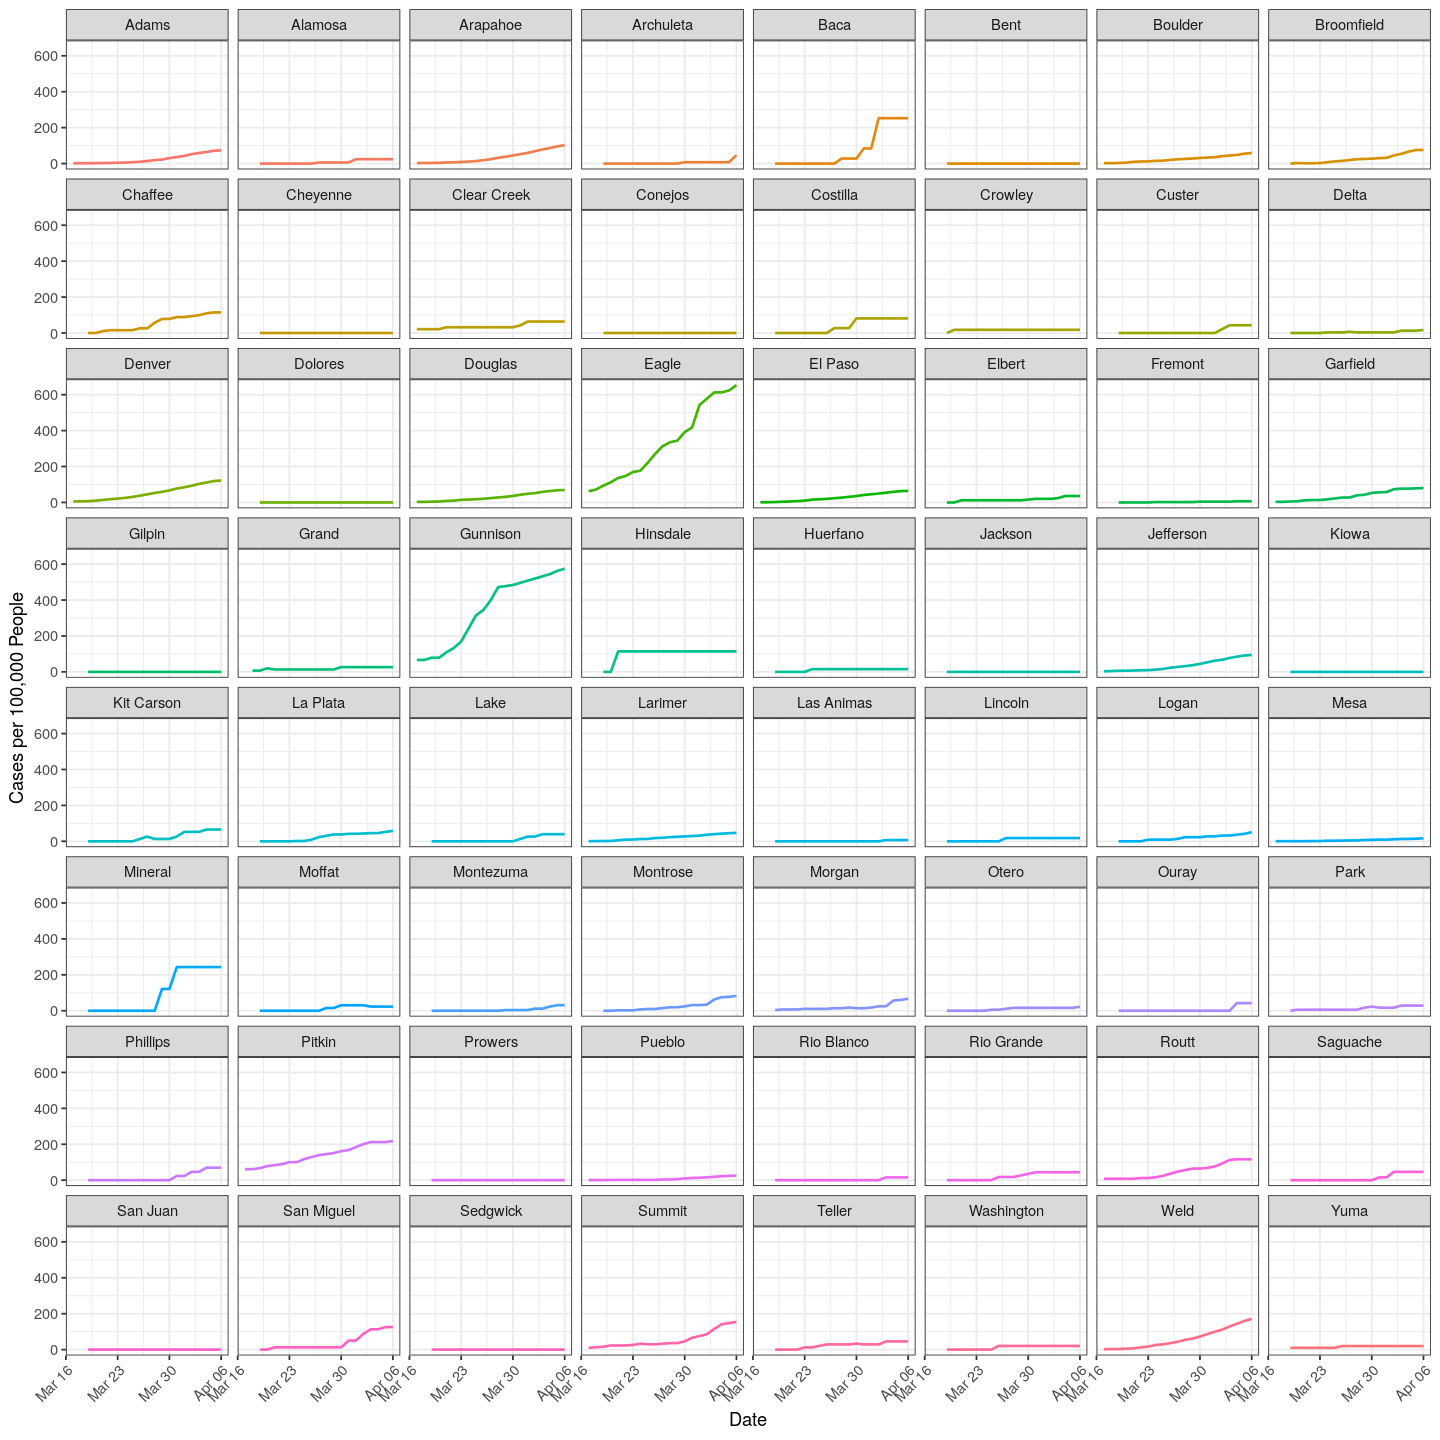

In [9]:
# plot results
library(ggplot2)
options(repr.plot.height = 12, repr.plot.width = 12)
ggplot(data = daily_cases_cty, aes(x = date, y = cases_100k, color = attribute)) + 
    geom_line(size = 0.75) +
    facet_wrap(~attribute) +
    xlab('Date') +
    ylab('Cases per 100,000 People') +
    theme_bw() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    theme(legend.position = 'none')

Warning message:
“Transformation introduced infinite values in continuous y-axis”


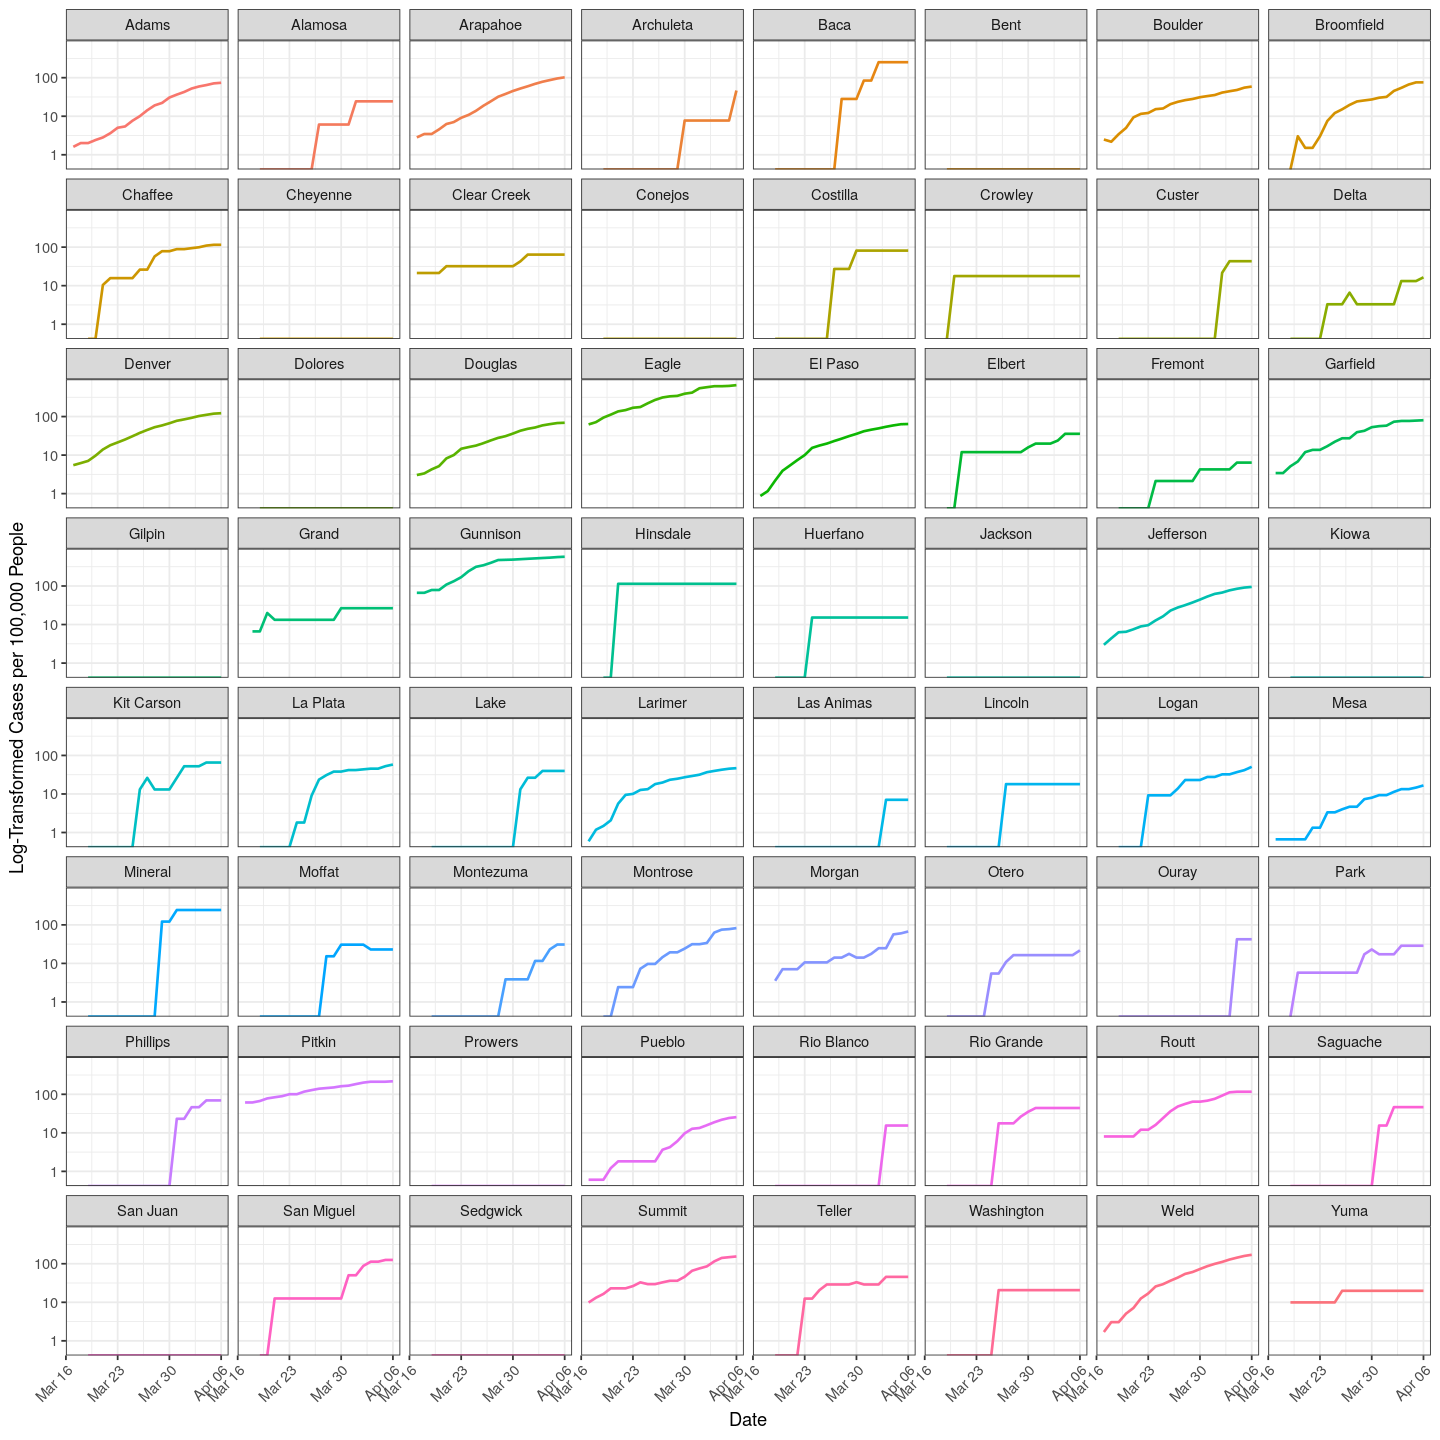

In [10]:
# with logarithmic y-axis
options(repr.plot.height = 12, repr.plot.width = 12)
ggplot(data = daily_cases_cty, aes(x = date, y = cases_100k, color = attribute)) + 
    geom_line(size = 0.75) +
    facet_wrap(~attribute) +
    scale_y_log10() +
    xlab('Date') +
    ylab('Log-Transformed Cases per 100,000 People') +
    theme_bw() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    theme(legend.position = 'none')

## County Clusters (Experimental)

In [11]:
library(classInt)

In [12]:
# convert daily cases back to list format
daily_cases_split <- split(daily_cases_cty, daily_cases_cty$date)

In [13]:
# need to remove 3/17 and 3/18
# since not all counties reporting
daily_cases_split <- daily_cases_split[-c(1:2)]

In [14]:
# daily breaks
k = 5
bx <- lapply(daily_cases_split, function(x){
        
    cut(x$cases_100k, 
        classIntervals(x$cases_100k,
                       style = 'jenks',
                       n = k)$brk,
#                        )$brk,
        include.lowest = T,
        )
#         labels = 1:k)
    
})

In [15]:
bx <- do.call(cbind, bx)
rownames(bx) <- sort(unique(daily_cases_cty$attribute))

In [16]:
d <- dist(bx, method = 'manhattan')
d <- as.matrix(d)

In [17]:
library(apcluster)
source('../felis/code/apcluster_helper.R')
apc <- apcluster(-d)
apc


Attaching package: ‘apcluster’


The following object is masked from ‘package:stats’:

    heatmap





APResult object

Number of samples     =  64 
Number of iterations  =  428 
Input preference      =  -13 
Sum of similarities   =  -120 
Sum of preferences    =  -143 
Net similarity        =  -263 
Number of clusters    =  11 

Exemplars:
   Bent Boulder Crowley Eagle Gunnison Hinsdale La Plata Mineral Pitkin 
   Saguache Weld
Clusters:
   Cluster 1, exemplar Bent:
      Alamosa Archuleta Bent Cheyenne Conejos Delta Dolores Elbert Fremont 
      Gilpin Huerfano Jackson Kiowa Las Animas Lincoln Mesa Moffat Montezuma 
      Otero Park Prowers Pueblo Rio Blanco San Juan Sedgwick Washington
   Cluster 2, exemplar Boulder:
      Arapahoe Boulder Clear Creek Douglas El Paso Garfield Larimer Morgan 
      Teller
   Cluster 3, exemplar Crowley:
      Crowley Grand Yuma
   Cluster 4, exemplar Eagle:
      Eagle
   Cluster 5, exemplar Gunnison:
      Gunnison
   Cluster 6, exemplar Hinsdale:
      Hinsdale
   Cluster 7, exemplar La Plata:
      Adams Broomfield Costilla Kit Carson La Plata Log

In [18]:
# load county boundaries
library(sf)
counties <- read_sf('data', 'cb_2018_us_county_500k')
counties <- counties[counties$STATEFP == '08',]
counties <- counties[match(rownames(bx), counties$NAME),]

Linking to GEOS 3.5.1, GDAL 2.1.2, PROJ 4.9.3



In [19]:
# assign cluster labels
counties['cluster'] <- factor(clust_vec(apc))

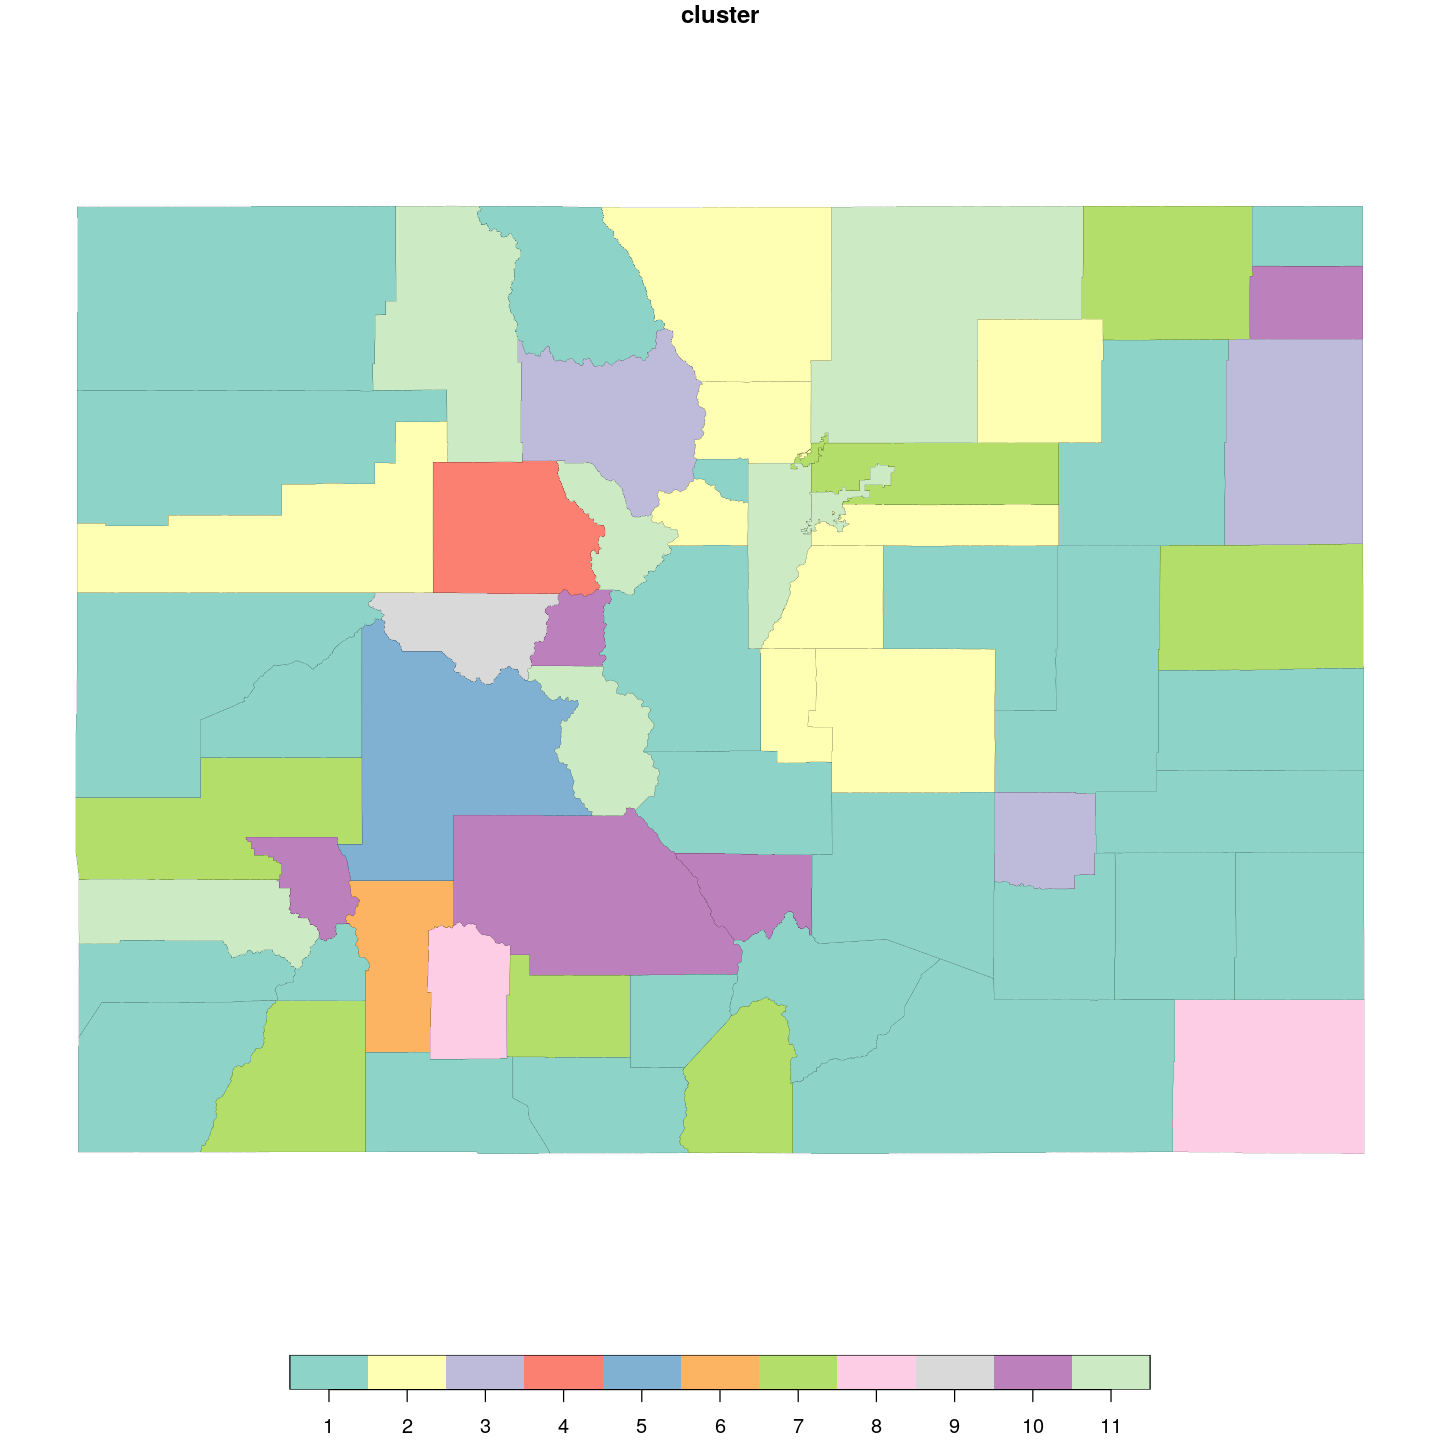

In [20]:
plot(counties['cluster'], lwd = 0.1)